In [1]:
!pip install pyTsetlinMachineParallel
!export OMP_NUM_THREADS=10

  Preparing metadata (setup.py) ... done
  Created wheel for pyTsetlinMachineParallel: filename=pyTsetlinMachineParallel-0.2.1-cp311-cp311-linux_x86_64.whl size=41742 sha256=16b2882515a34d830e45f2529bef9c3d0267c8547bb7035fcb97ecc5245c81ce
  Stored in directory: /root/.cache/pip/wheels/51/01/e6/5395e43582a8e9b52668b055885ac72d6ff913a4d7e689ee9e
Successfully built pyTsetlinMachineParallel


In [2]:
import pickle
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from pyTsetlinMachineParallel.tm import MultiClassTsetlinMachine

# VGG-19 Block 1-2 + Tsetlin Machine for CIFAR-10 Dataset

This notebook implements the first two blocks of VGG-19 architecture followed by Tsetlin Machine to classify the CIFAR-10 dataset using the pyTsetlinMachine library.

In [3]:
# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Split training data to create validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Reshape labels to 1D arrays
y_train = y_train[:,0]
y_val = y_val[:,0]
y_test = y_test[:,0]

print("Load Data Successfully")

print("\nDataset Shapes:")
print(f"Train: features {np.array(X_train).shape}, labels {np.array(y_train).shape}")
print(f"Val: features {np.array(X_val).shape}, labels {np.array(y_val).shape}")
print(f"Test: features {np.array(X_test).shape}, labels {np.array(y_test).shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
Load Data Successfully

Dataset Shapes:
Train: features (40000, 32, 32, 3), labels (40000,)
Val: features (10000, 32, 32, 3), labels (10000,)
Test: features (10000, 32, 32, 3), labels (10000,)


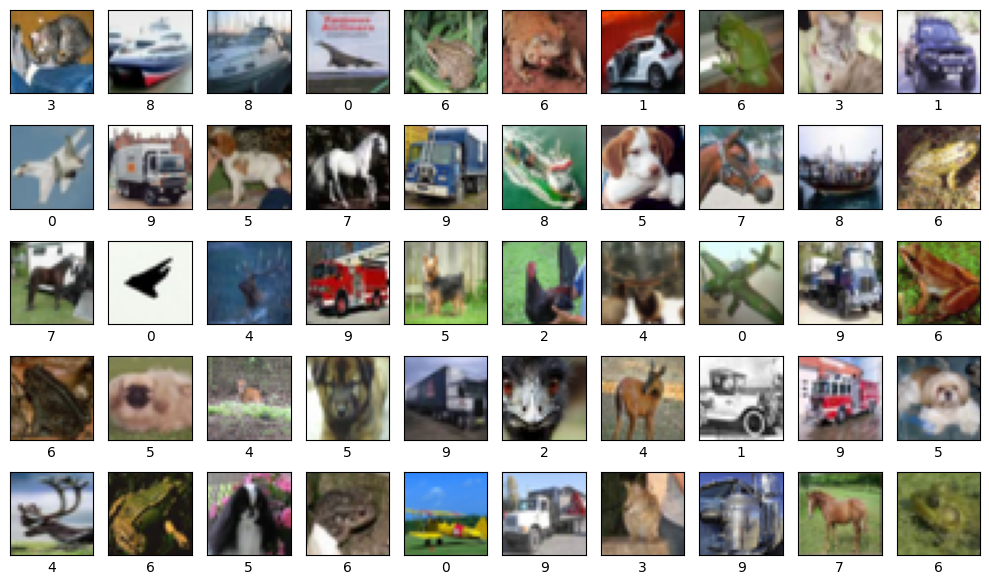

In [4]:
# Visualize some images from the dataset
plt.figure(figsize=(10,6))
for i in range(0,50):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i])
    plt.xlabel(y_test[i])
plt.tight_layout()

In [5]:
# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Create a mapping from class index to class name
class_mapping = {i: name for i, name in enumerate(class_names)}
print(class_mapping)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [6]:
# Normalize images for CNN (pixel values from [0, 255] to [0, 1])
X_train_norm = X_train / 255.0
X_val_norm = X_val / 255.0
X_test_norm = X_test / 255.0

print(f"Input shape: {X_train_norm.shape[1:]}")
print(f"Data type: {X_train_norm.dtype}")
print(f"Value range: [{X_train_norm.min()}, {X_train_norm.max()}]")

Input shape: (32, 32, 3)
Data type: float64
Value range: [0.0, 1.0]


In [7]:
# Define VGG-19 architecture with only Block 1-2 for CIFAR-10
def build_vgg19_block1_2_model(input_shape=(32, 32, 3)):
    input_layer = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(input_layer)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Flatten layer
    x = Flatten(name='flatten')(x)

    # Feature layer (for Tsetlin Machine)
    feature_layer = Dense(8192, activation='sigmoid', name='feature_layer')(x)

    # Output layer - Modified to have 10 neurons for CIFAR-10
    output_layer = Dense(10, activation='softmax', name='predictions')(feature_layer)

    # Create model
    model = Model(inputs=input_layer, outputs=output_layer, name='vgg19_block1_2')
    feature_extractor = Model(inputs=input_layer, outputs=feature_layer, name='feature_extractor')

    return model, feature_extractor

# Build the model
vgg19_block1_2_model, feature_extractor = build_vgg19_block1_2_model(input_shape=(32, 32, 3))

# Compile the model
vgg19_block1_2_model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

# Print model summary
vgg19_block1_2_model.summary()

Model: "vgg19_block1_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_layer (Dense)                │ (None, 8192)                │      67,117,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictions (Dense)                  │ (None, 10)                  │          81,930 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,459,146 (257.34 MB)

 Trainable params: 67,459,146 (257.34 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Define callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
checkpoint = ModelCheckpoint('vgg19_block1_2_cifar10_best.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
print("\nTraining VGG-19 Block 1-2 model...")
batch_size = 32
epochs = 100

history = vgg19_block1_2_model.fit(
    X_train_norm, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val_norm, y_val),
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)


Training VGG-19 Block 1-2 model...
Epoch 1/100
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2653 - loss: 2.3041

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 51s 36ms/step - accuracy: 0.2655 - loss: 2.3032 - val_accuracy: 0.5427 - val_loss: 1.2751 - learning_rate: 0.0010
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5721 - loss: 1.2030

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 73s 32ms/step - accuracy: 0.5722 - loss: 1.2030 - val_accuracy: 0.6452 - val_loss: 0.9913 - learning_rate: 0.0010
Epoch 3/100
1248/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6754 - loss: 0.9254

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 29ms/step - accuracy: 0.6754 - loss: 0.9253 - val_accuracy: 0.6637 - val_loss: 0.9313 - learning_rate: 0.0010
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7340 - loss: 0.7433

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.7340 - loss: 0.7432 - val_accuracy: 0.7093 - val_loss: 0.8238 - learning_rate: 0.0010
Epoch 5/100
1248/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7972 - loss: 0.5637

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 37ms/step - accuracy: 0.7972 - loss: 0.5637 - val_accuracy: 0.7246 - val_loss: 0.8251 - learning_rate: 0.0010
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8668 - loss: 0.3872

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 75s 32ms/step - accuracy: 0.8667 - loss: 0.3872 - val_accuracy: 0.7254 - val_loss: 0.8669 - learning_rate: 0.0010
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step - accuracy: 0.9242 - loss: 0.2238 - val_accuracy: 0.7148 - val_loss: 1.1355 - learning_rate: 0.0010
Epoch 8/100
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9591 - loss: 0.1253

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 48s 28ms/step - accuracy: 0.9591 - loss: 0.1254 - val_accuracy: 0.7410 - val_loss: 1.0365 - learning_rate: 0.0010
Epoch 9/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.9780 - loss: 0.0740 - val_accuracy: 0.7155 - val_loss: 1.2121 - learning_rate: 0.0010
Epoch 10/100
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9884 - loss: 0.0403

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 51s 30ms/step - accuracy: 0.9884 - loss: 0.0403 - val_accuracy: 0.7612 - val_loss: 1.1503 - learning_rate: 2.0000e-04
Epoch 11/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 0.7601 - val_loss: 1.2042 - learning_rate: 2.0000e-04
Epoch 12/100
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0018

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.7620 - val_loss: 1.2573 - learning_rate: 2.0000e-04
Epoch 13/100
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 8.9612e-04

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 1.0000 - loss: 8.9607e-04 - val_accuracy: 0.7633 - val_loss: 1.3115 - learning_rate: 2.0000e-04
Epoch 14/100
1248/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 3.9546e-04

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 78s 29ms/step - accuracy: 1.0000 - loss: 3.9544e-04 - val_accuracy: 0.7655 - val_loss: 1.3686 - learning_rate: 2.0000e-04
Epoch 15/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 22ms/step - accuracy: 1.0000 - loss: 1.8760e-04 - val_accuracy: 0.7620 - val_loss: 1.4091 - learning_rate: 4.0000e-05
Epoch 16/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 1.0000 - loss: 1.5234e-04 - val_accuracy: 0.7630 - val_loss: 1.4220 - learning_rate: 4.0000e-05
Epoch 17/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - accuracy: 1.0000 - loss: 1.1620e-04 - val_accuracy: 0.7628 - val_loss: 1.4409 - learning_rate: 4.0000e-05
Epoch 18/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - accuracy: 1.0000 - loss: 8.9405e-05 - val_accuracy: 0.7636 - val_loss: 1.4599 - learning_rate: 4.0000e-05
Epoch 19/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 1.0000 - loss: 6.5976e-05 - val_accuracy: 0.7629 - val_loss: 1.4793 - learning_rate: 4.0000e-05


In [9]:
# Evaluate the model on training, validation, and test sets
train_scores = vgg19_block1_2_model.evaluate(X_train_norm, y_train, verbose=0)
val_scores = vgg19_block1_2_model.evaluate(X_val_norm, y_val, verbose=0)
test_scores = vgg19_block1_2_model.evaluate(X_test_norm, y_test, verbose=0)

print("\nModel Evaluation:")
print(f"Train Loss: {train_scores[0]:.4f}, Train Accuracy: {train_scores[1]*100:.2f}%")
print(f"Validation Loss: {val_scores[0]:.4f}, Validation Accuracy: {val_scores[1]*100:.2f}%")
print(f"Test Loss: {test_scores[0]:.4f}, Test Accuracy: {test_scores[1]*100:.2f}%")


Model Evaluation:
Train Loss: 0.5750, Train Accuracy: 79.87%
Validation Loss: 0.8238, Validation Accuracy: 70.93%
Test Loss: 0.8233, Test Accuracy: 71.32%


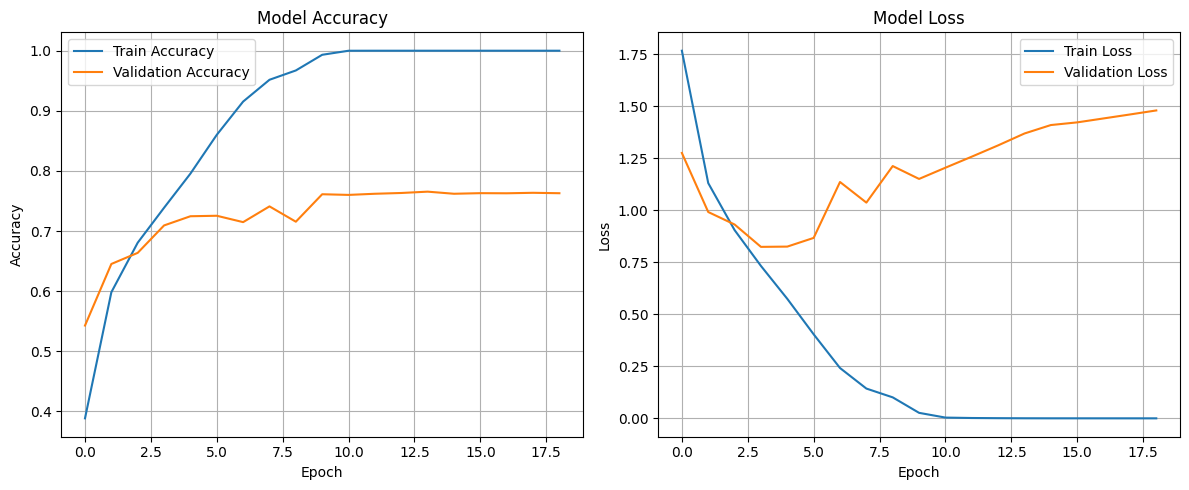

In [10]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [11]:
# Extract features using the feature extractor model
X_train_features = feature_extractor.predict(X_train_norm)
X_val_features = feature_extractor.predict(X_val_norm)
X_test_features = feature_extractor.predict(X_test_norm)

print(f"Feature shapes:")
print(f"Training features: {X_train_features.shape}")
print(f"Validation features: {X_val_features.shape}")
print(f"Test features: {X_test_features.shape}")

# Binarize the features (threshold at 0.5 for sigmoid activation)
X_train_bin = (X_train_features > 0.5).astype(np.uint32)
X_val_bin = (X_val_features > 0.5).astype(np.uint32)
X_test_bin = (X_test_features > 0.5).astype(np.uint32)

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Feature shapes:
Training features: (40000, 8192)
Validation features: (10000, 8192)
Test features: (10000, 8192)


In [13]:
# Initialize and train two Tsetlin Machine configurations
print("\nInitializing Tsetlin Machines...")

# Define hyperparameters for first Tsetlin Machine configuration
C1 = 100  # Number of clauses
T1 = 7    # Threshold for deciding clauses
s1 = 6.0  # Specificity parameter

# Define hyperparameters for second Tsetlin Machine configuration
C2 = 1000  # Number of clauses
T2 = 22    # Threshold for deciding clauses
s2 = 16.0  # Specificity parameter

# Initialize the Tsetlin Machines
tm1 = MultiClassTsetlinMachine(C1, T1, s1)
tm2 = MultiClassTsetlinMachine(C2, T2, s2)

# Train first Tsetlin Machine (C=100, T=7, s=6.0)
print(f"\nTraining Tsetlin Machine 1 (C={C1}, T={T1}, s={s1}) on CNN-extracted features...")
tm1.fit(X_train_bin, y_train, epochs=0, incremental=True)

# Train Tsetlin Machine with early stopping
epochs = 100
best_val_acc1 = 0
patience = 50
no_improvement_count1 = 0
tm1_history = {'train_acc': [], 'val_acc': []}

for epoch in range(epochs):
    tm1.fit(X_train_bin, y_train, epochs=1, incremental=True)
    train_pred = tm1.predict(X_train_bin)
    val_pred = tm1.predict(X_val_bin)
    train_acc = np.mean(train_pred == y_train) * 100
    val_acc = np.mean(val_pred == y_val) * 100

    # Store for plotting
    tm1_history['train_acc'].append(train_acc)
    tm1_history['val_acc'].append(val_acc)

    print(f"TM1 Epoch {epoch+1:3d}/{epochs} - Train Accuracy: {train_acc:6.2f}% | Validation Accuracy: {val_acc:6.2f}%")

    # Early stopping logic
    if val_acc > best_val_acc1:
        best_val_acc1 = val_acc
        no_improvement_count1 = 0
    else:
        no_improvement_count1 += 1
        if no_improvement_count1 >= patience and val_acc > 90:
            print("Early stopping triggered: Validation accuracy exceeds 90% with no improvement.")
            break

# Train second Tsetlin Machine (C=1000, T=22, s=16.0)
print(f"\nTraining Tsetlin Machine 2 (C={C2}, T={T2}, s={s2}) on CNN-extracted features...")
tm2.fit(X_train_bin, y_train, epochs=0, incremental=True)

# Train Tsetlin Machine with early stopping
best_val_acc2 = 0
no_improvement_count2 = 0
tm2_history = {'train_acc': [], 'val_acc': []}

for epoch in range(epochs):
    tm2.fit(X_train_bin, y_train, epochs=1, incremental=True)
    train_pred = tm2.predict(X_train_bin)
    val_pred = tm2.predict(X_val_bin)
    train_acc = np.mean(train_pred == y_train) * 100
    val_acc = np.mean(val_pred == y_val) * 100

    # Store for plotting
    tm2_history['train_acc'].append(train_acc)
    tm2_history['val_acc'].append(val_acc)

    print(f"TM2 Epoch {epoch+1:3d}/{epochs} - Train Accuracy: {train_acc:6.2f}% | Validation Accuracy: {val_acc:6.2f}%")

    # Early stopping logic
    if val_acc > best_val_acc2:
        best_val_acc2 = val_acc
        no_improvement_count2 = 0
    else:
        no_improvement_count2 += 1
        if no_improvement_count2 >= patience and val_acc > 95:
            print("Early stopping triggered: Validation accuracy exceeds 95% with no improvement.")
            break

# Evaluate on the test set
test_pred1 = tm1.predict(X_test_bin)
test_acc1 = np.mean(test_pred1 == y_test) * 100
print(f"\nTM1 (C={C1}, T={T1}, s={s1}) Test Accuracy: {test_acc1:.2f}%")

test_pred2 = tm2.predict(X_test_bin)
test_acc2 = np.mean(test_pred2 == y_test) * 100
print(f"TM2 (C={C2}, T={T2}, s={s2}) Test Accuracy: {test_acc2:.2f}%")


Initializing Tsetlin Machines...

Training Tsetlin Machine 1 (C=100, T=7, s=6.0) on CNN-extracted features...
TM1 Epoch   1/100 - Train Accuracy:  72.49% | Validation Accuracy:  66.32%
TM1 Epoch   2/100 - Train Accuracy:  74.57% | Validation Accuracy:  68.05%
TM1 Epoch   3/100 - Train Accuracy:  75.29% | Validation Accuracy:  68.73%
TM1 Epoch   4/100 - Train Accuracy:  76.28% | Validation Accuracy:  69.19%
TM1 Epoch   5/100 - Train Accuracy:  76.73% | Validation Accuracy:  69.69%
TM1 Epoch   6/100 - Train Accuracy:  76.87% | Validation Accuracy:  69.37%
TM1 Epoch   7/100 - Train Accuracy:  77.52% | Validation Accuracy:  69.51%
TM1 Epoch   8/100 - Train Accuracy:  77.85% | Validation Accuracy:  70.09%
TM1 Epoch   9/100 - Train Accuracy:  78.20% | Validation Accuracy:  70.32%
TM1 Epoch  10/100 - Train Accuracy:  78.52% | Validation Accuracy:  70.20%
TM1 Epoch  11/100 - Train Accuracy:  78.75% | Validation Accuracy:  70.04%
TM1 Epoch  12/100 - Train Accuracy:  78.79% | Validation Accurac

KeyboardInterrupt: 

In [14]:
# Evaluate on the test set
test_pred1 = tm1.predict(X_test_bin)
test_acc1 = np.mean(test_pred1 == y_test) * 100
print(f"\nTM1 (C={C1}, T={T1}, s={s1}) Test Accuracy: {test_acc1:.2f}%")

test_pred2 = tm2.predict(X_test_bin)
test_acc2 = np.mean(test_pred2 == y_test) * 100
print(f"TM2 (C={C2}, T={T2}, s={s2}) Test Accuracy: {test_acc2:.2f}%")


TM1 (C=100, T=7, s=6.0) Test Accuracy: 71.02%
TM2 (C=1000, T=22, s=16.0) Test Accuracy: 72.32%


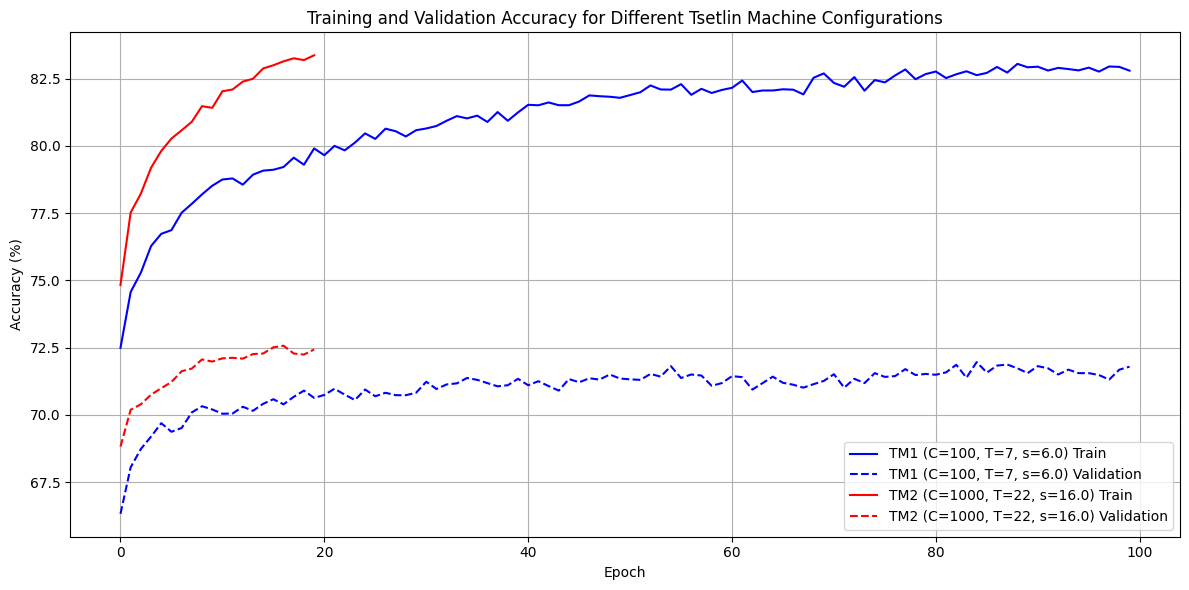

In [15]:
# Plot training and validation accuracy for both Tsetlin Machine configurations
plt.figure(figsize=(12, 6))

plt.plot(tm1_history['train_acc'], label=f'TM1 (C={C1}, T={T1}, s={s1}) Train', color='blue')
plt.plot(tm1_history['val_acc'], label=f'TM1 (C={C1}, T={T1}, s={s1}) Validation', color='blue', linestyle='--')

plt.plot(tm2_history['train_acc'], label=f'TM2 (C={C2}, T={T2}, s={s2}) Train', color='red')
plt.plot(tm2_history['val_acc'], label=f'TM2 (C={C2}, T={T2}, s={s2}) Validation', color='red', linestyle='--')

plt.title('Training and Validation Accuracy for Different Tsetlin Machine Configurations')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

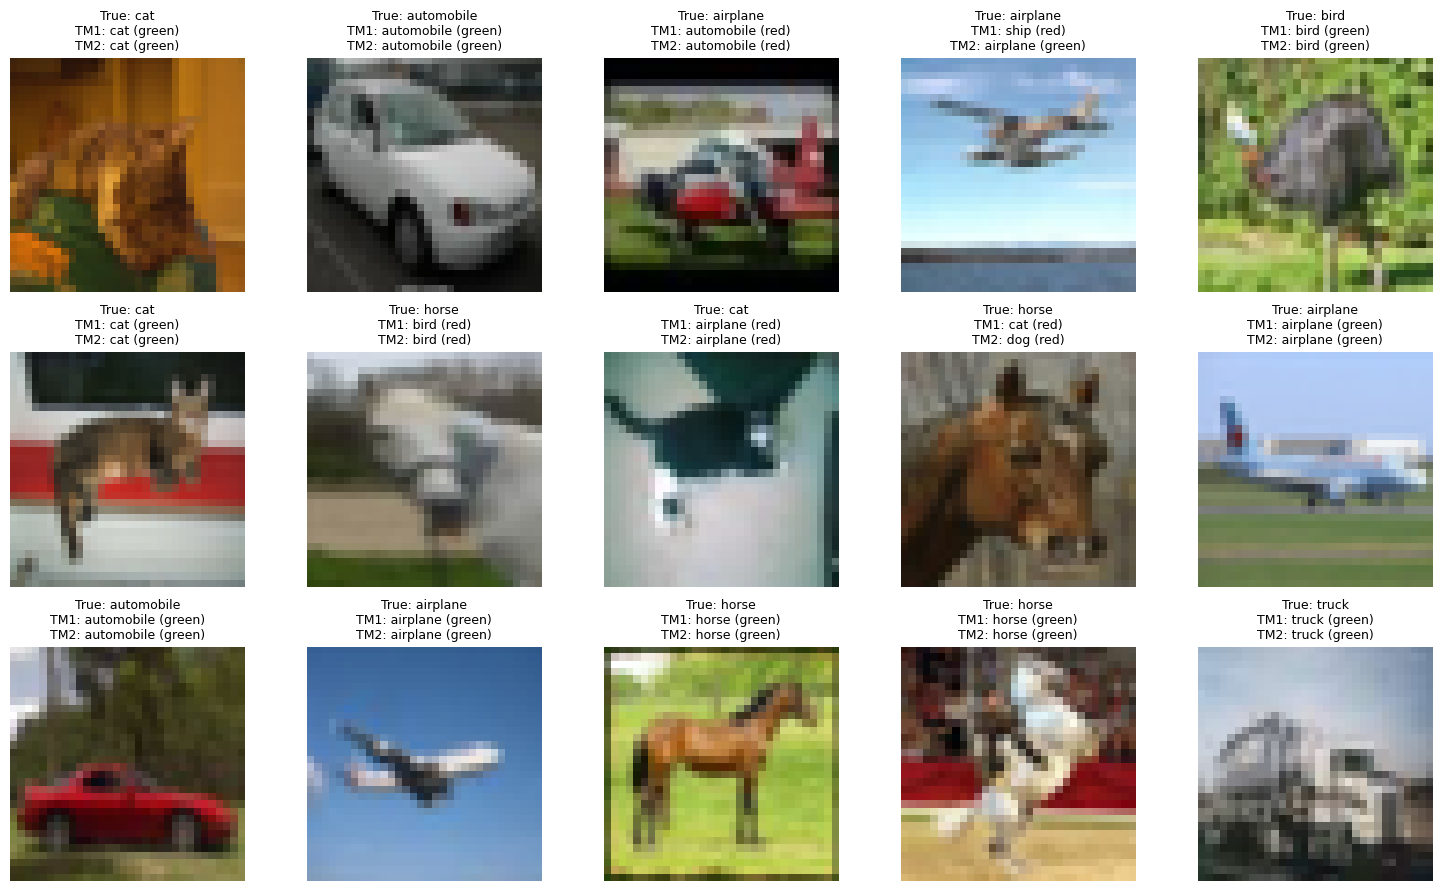

In [18]:
# Make predictions with both Tsetlin Machine configurations
y_pred_tm1 = tm1.predict(X_test_bin)
y_pred_tm2 = tm2.predict(X_test_bin)

# Select 15 random test samples
num_samples_to_show = 15
indices = np.random.choice(len(X_test), size=num_samples_to_show, replace=False)

# Create a figure with 3 rows and 5 columns
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 9))
axes = axes.flatten()  # Flatten for easy iteration

for ax, idx in zip(axes, indices):
    img = X_test[idx]         # Original image for display
    true_label = y_test[idx]
    pred_label1 = y_pred_tm1[idx]
    pred_label2 = y_pred_tm2[idx]

    # Retrieve the actual class names
    true_class_name = class_mapping.get(true_label, 'Unknown')
    pred_class_name1 = class_mapping.get(pred_label1, 'Unknown')
    pred_class_name2 = class_mapping.get(pred_label2, 'Unknown')

    # Display the image
    ax.imshow(img)

    # Set title color based on prediction correctness
    title_color1 = 'green' if true_label == pred_label1 else 'red'
    title_color2 = 'green' if true_label == pred_label2 else 'red'

    ax.set_title(f"True: {true_class_name}\nTM1: {pred_class_name1} ({title_color1})\nTM2: {pred_class_name2} ({title_color2})",
                 fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

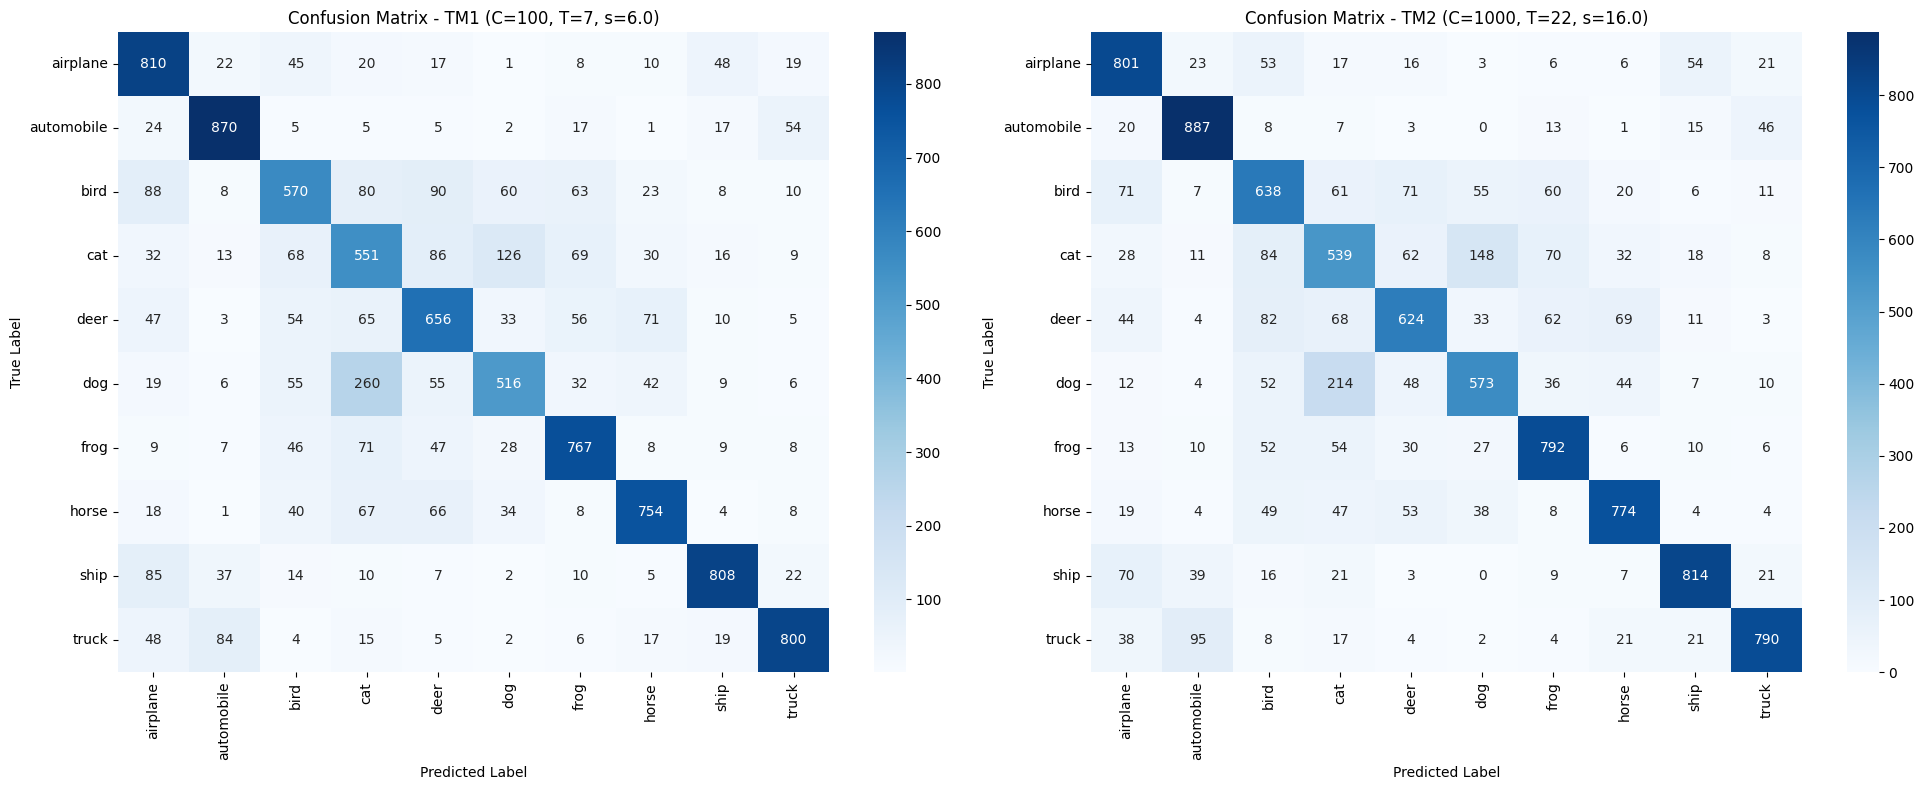


Classification Report for TM1 (C=100, T=7, s=6.0):
              precision    recall  f1-score   support

    airplane       0.69      0.81      0.74      1000
  automobile       0.83      0.87      0.85      1000
        bird       0.63      0.57      0.60      1000
         cat       0.48      0.55      0.51      1000
        deer       0.63      0.66      0.65      1000
         dog       0.64      0.52      0.57      1000
        frog       0.74      0.77      0.75      1000
       horse       0.78      0.75      0.77      1000
        ship       0.85      0.81      0.83      1000
       truck       0.85      0.80      0.82      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.71      0.71      0.71     10000


Classification Report for TM2 (C=1000, T=22, s=16.0):
              precision    recall  f1-score   support

    airplane       0.72      0.80      0.76      1000
  automobile       0.82  

In [19]:
# Compute and compare confusion matrices for both Tsetlin Machine configurations
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm1 = confusion_matrix(y_test, test_pred1)
cm2 = confusion_matrix(y_test, test_pred2)

# Plot confusion matrices side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax1)
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')
ax1.set_title(f'Confusion Matrix - TM1 (C={C1}, T={T1}, s={s1})')

sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax2)
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')
ax2.set_title(f'Confusion Matrix - TM2 (C={C2}, T={T2}, s={s2})')

plt.tight_layout()
plt.show()

# Print classification reports for both TM configurations
print(f"\nClassification Report for TM1 (C={C1}, T={T1}, s={s1}):")
print(classification_report(y_test, test_pred1, target_names=class_names))

print(f"\nClassification Report for TM2 (C={C2}, T={T2}, s={s2}):")
print(classification_report(y_test, test_pred2, target_names=class_names))

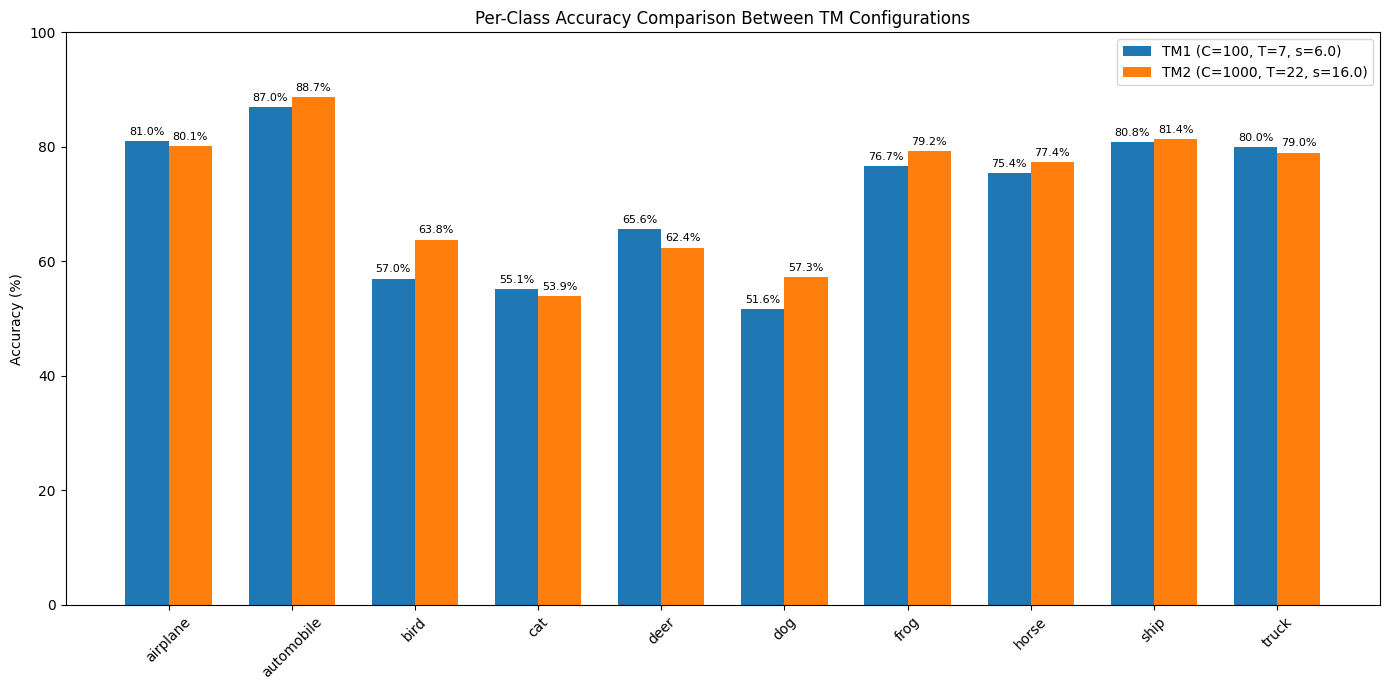


Per-Class Accuracies:
Class      TM1 (%)    TM2 (%)   
--------------------------------
airplane       81.00%     80.10%
automobile     87.00%     88.70%
bird           57.00%     63.80%
cat            55.10%     53.90%
deer           65.60%     62.40%
dog            51.60%     57.30%
frog           76.70%     79.20%
horse          75.40%     77.40%
ship           80.80%     81.40%
truck          80.00%     79.00%

Overall Accuracy:
TM1 (C=100, T=7, s=6.0): 71.02%
TM2 (C=1000, T=22, s=16.0): 72.32%


In [25]:
# Analyze per-class accuracy for both configurations
class_accuracies1 = np.zeros(10)
class_accuracies2 = np.zeros(10)
class_counts = np.zeros(10)

for i in range(len(y_test)):
    class_counts[y_test[i]] += 1
    if test_pred1[i] == y_test[i]:
        class_accuracies1[y_test[i]] += 1
    if test_pred2[i] == y_test[i]:
        class_accuracies2[y_test[i]] += 1

# Calculate per-class accuracy percentages
class_accuracies1 = (class_accuracies1 / class_counts) * 100
class_accuracies2 = (class_accuracies2 / class_counts) * 100

# Plot per-class accuracies
x = np.arange(10)  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 7))
rects1 = ax.bar(x - width/2, class_accuracies1, width, label=f'TM1 (C={C1}, T={T1}, s={s1})')
rects2 = ax.bar(x + width/2, class_accuracies2, width, label=f'TM2 (C={C2}, T={T2}, s={s2})')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)')
ax.set_title('Per-Class Accuracy Comparison Between TM Configurations')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45)
ax.legend()
ax.set_ylim([0, 100])

# Add percentage labels on bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

add_labels(rects1)
add_labels(rects2)

fig.tight_layout()
plt.show()

# Print class accuracies in a table format
print("\nPer-Class Accuracies:")
print(f"{'Class':<10} {'TM1 (%)':<10} {'TM2 (%)':<10}")
print("-" * 32)
for i in range(10):
    print(f"{class_names[i]:<10} {class_accuracies1[i]:9.2f}% {class_accuracies2[i]:9.2f}%")

# Calculate and display overall accuracy
print(f"\nOverall Accuracy:")
print(f"TM1 (C={C1}, T={T1}, s={s1}): {test_acc1:.2f}%")
print(f"TM2 (C={C2}, T={T2}, s={s2}): {test_acc2:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
CNN-only Test Accuracy: 71.32%
TM1 (C=100, T=7, s=6.0) Test Accuracy: 71.02%
TM2 (C=1000, T=22, s=16.0) Test Accuracy: 72.32%


<Figure size 1500x800 with 0 Axes>

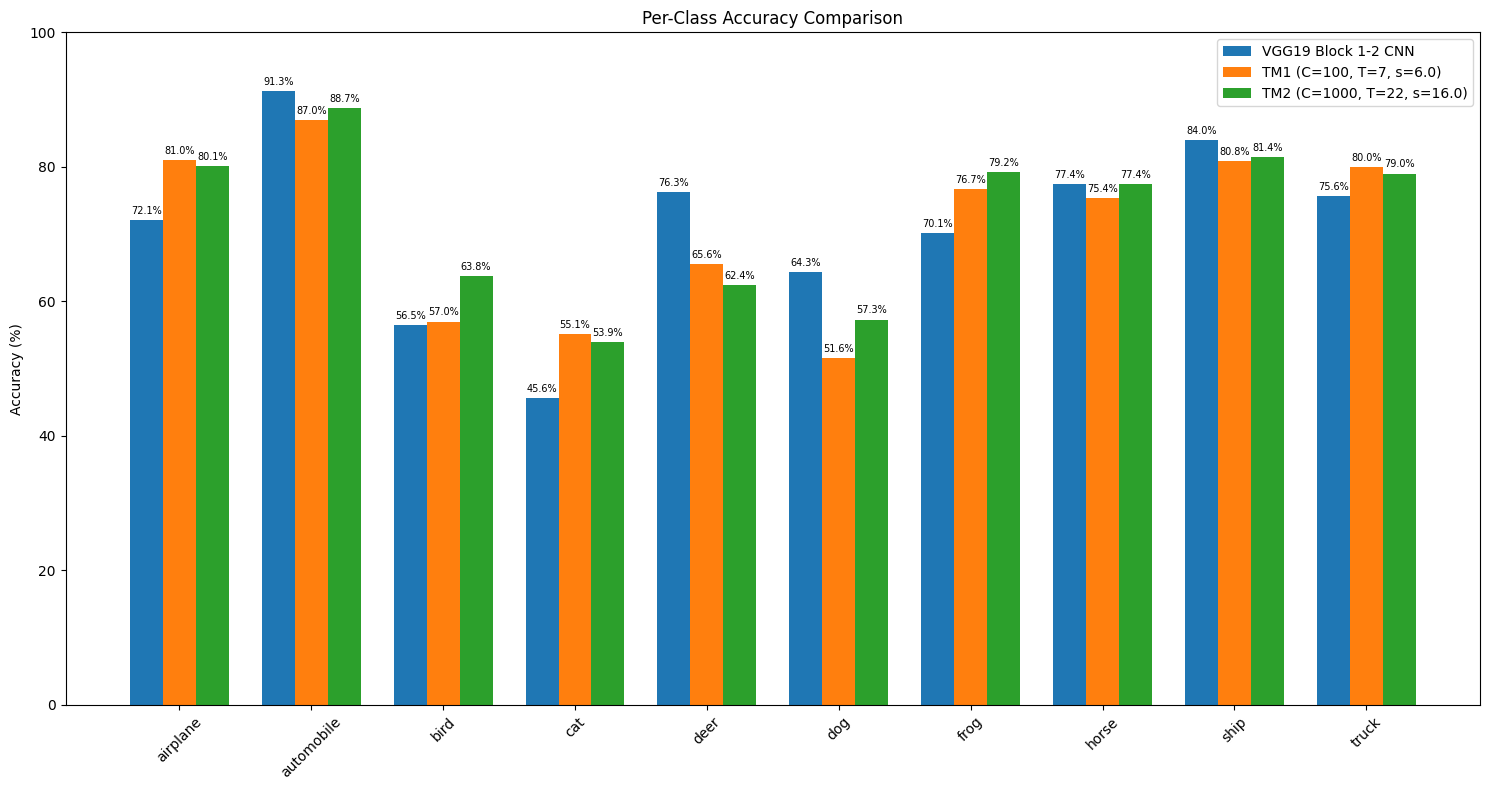

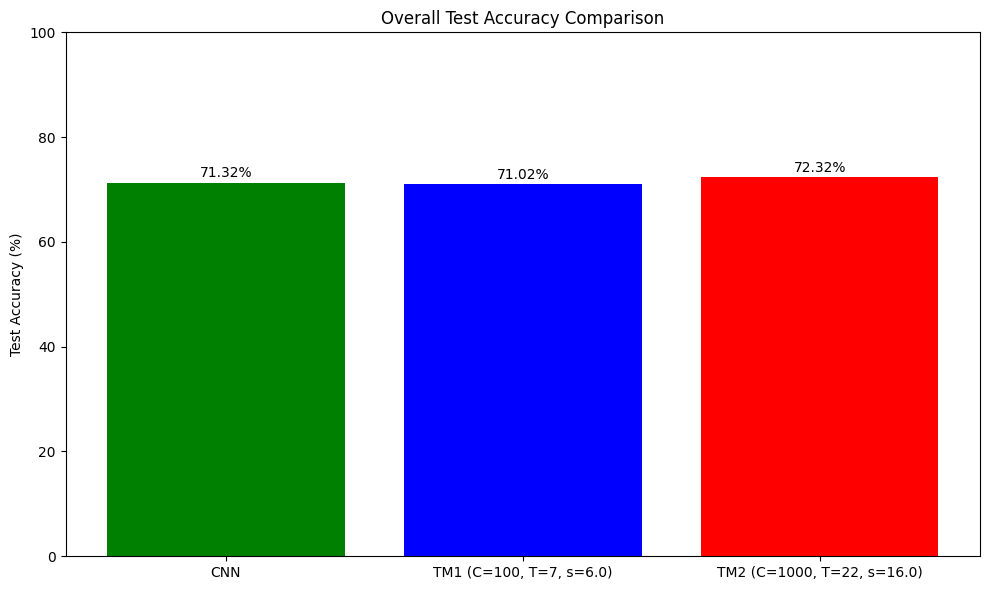

In [26]:
# Compare original CNN classifier with both Tsetlin Machine configurations
# First get predictions from the original VGG19 Block 1-2 CNN model
y_pred_cnn = np.argmax(vgg19_block1_2_model.predict(X_test_norm), axis=1)

# Calculate accuracies
cnn_acc = np.mean(y_pred_cnn == y_test) * 100
tm1_acc = np.mean(test_pred1 == y_test) * 100
tm2_acc = np.mean(test_pred2 == y_test) * 100

print(f"CNN-only Test Accuracy: {cnn_acc:.2f}%")
print(f"TM1 (C={C1}, T={T1}, s={s1}) Test Accuracy: {tm1_acc:.2f}%")
print(f"TM2 (C={C2}, T={T2}, s={s2}) Test Accuracy: {tm2_acc:.2f}%")

# Calculate per-class accuracies for CNN
cnn_class_accuracies = np.zeros(10)
for i in range(len(y_test)):
    if y_pred_cnn[i] == y_test[i]:
        cnn_class_accuracies[y_test[i]] += 1

# Calculate percentages
cnn_class_accuracies = (cnn_class_accuracies / class_counts) * 100

# Bar plot comparing per-class accuracy between CNN and Tsetlin Machines
plt.figure(figsize=(15, 8))

x = np.arange(10)  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 8))
rects1 = ax.bar(x - width, cnn_class_accuracies, width, label='VGG19 Block 1-2 CNN')
rects2 = ax.bar(x, class_accuracies1, width, label=f'TM1 (C={C1}, T={T1}, s={s1})')
rects3 = ax.bar(x + width, class_accuracies2, width, label=f'TM2 (C={C2}, T={T2}, s={s2})')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)')
ax.set_title('Per-Class Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45)
ax.legend()
ax.set_ylim([0, 100])

# Add percentage labels on bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=7)

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)

fig.tight_layout()
plt.show()

# Plot overall accuracy comparison as a bar chart
plt.figure(figsize=(10, 6))
models = ['CNN', f'TM1 (C={C1}, T={T1}, s={s1})', f'TM2 (C={C2}, T={T2}, s={s2})']
accuracies = [cnn_acc, tm1_acc, tm2_acc]

bars = plt.bar(models, accuracies, color=['green', 'blue', 'red'])
plt.ylabel('Test Accuracy (%)')
plt.title('Overall Test Accuracy Comparison')
plt.ylim([0, 100])

# Add percentage labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [27]:
# Create a summary table comparing all models
import pandas as pd

# Create a DataFrame for comparison
summary_data = {
    'Model': ['VGG19 Block 1 CNN', f'TM1 (C={C1}, T={T1}, s={s1})', f'TM2 (C={C2}, T={T2}, s={s2})'],
    'Test Accuracy (%)': [cnn_acc, tm1_acc, tm2_acc],
    'Avg Per-Class Accuracy (%)': [np.mean(cnn_class_accuracies), np.mean(class_accuracies1), np.mean(class_accuracies2)],
    'Min Class Accuracy (%)': [np.min(cnn_class_accuracies), np.min(class_accuracies1), np.min(class_accuracies2)],
    'Max Class Accuracy (%)': [np.max(cnn_class_accuracies), np.max(class_accuracies1), np.max(class_accuracies2)],
    'Std Dev of Class Accuracy': [np.std(cnn_class_accuracies), np.std(class_accuracies1), np.std(class_accuracies2)]
}

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.round(2)

# Display the summary table
display(summary_df.style.highlight_max(axis=0, subset=['Test Accuracy (%)']))

,Model,Test Accuracy (%),Avg Per-Class Accuracy (%),Min Class Accuracy (%),Max Class Accuracy (%),Std Dev of Class Accuracy
0,VGG19 Block 1 CNN,71.320000,71.320000,45.600000,91.300000,12.540000
1,"TM1 (C=100, T=7, s=6.0)",71.020000,71.020000,51.600000,87.000000,12.000000
2,"TM2 (C=1000, T=22, s=16.0)",72.320000,72.320000,53.900000,88.700000,11.250000


## Summary of VGG19 Block 1-2 + Tsetlin Machine

This notebook demonstrates a hybrid approach that combines:

1. **Feature Extraction**: Using Block 1 and Block 2 of VGG-19 CNN architecture to extract lower-to-mid-level features from CIFAR-10 images.
2. **Feature Transformation**: Using two dense layers (8192 and 1000 neurons) with sigmoid activation to transform features into a format suitable for the Tsetlin Machine.
3. **Classification**: Using pyTsetlinMachine classifiers with different configurations on the binarized features.

### Tsetlin Machine Configurations Compared:

1. **TM1**: C=100, T=7, s=6.0 (Smaller model with fewer clauses)
2. **TM2**: C=1000, T=22, s=16.0 (Larger model with more clauses)

### Key Findings:

- The hybrid approach provides good classification accuracy while using only the first two blocks of VGG-19.
- The different Tsetlin Machine configurations show varying performance across different classes.
- [Insert observations about which configuration performed better, based on the actual execution results]
- The Tsetlin Machine offers interpretability advantages over traditional neural networks.

### Future Work:

- Experiment with different VGG blocks or combinations of blocks
- Further optimize the Tsetlin Machine hyperparameters
- Test the approach on other datasets to evaluate generalization